In [1]:
import os
os.chdir("../")

overwrite = False
dataset_name = 'nicu'
attr_suffix = ''
suffix = '_brady2' 

# Data

In [2]:
with open('run/settings.py', 'r') as file:
    exec(file.read())
with open('run/data.py', 'r') as file:
    exec(file.read())
# model_name = ''.join([dataset_name, attr_suffix, suffix]) 
# exec(open('run/configs/nicu_brady2.py', 'r').read())
# if attr_suffix == '':
#     config_dict = update_config(config_dict, custom_target_cols = ['label'])
# if 'open_vocab' in locals():
#     config_dict = update_config(config_dict, open_vocab = open_vocab)
# exec(open('run/prepare_datasets/nicu.py', 'r').read())
# with open('run/inputs.py', 'r') as file:
#     exec(file.read())

Random seed set to 333
using device:  cpu
nicu_brady2
nicu_brady2


final distribution of text prediction
description_histogram
Low variability.     14000
High variability.    11675
Name: count, dtype: int64
description_histogram
Low variability.     4000
High variability.    3336
Name: count, dtype: int64
description_histogram
Low variability.     2000
High variability.    1668
Name: count, dtype: int64
text
Low variability. No events.                       13562
High variability. No events.                      10622
High variability. Bradycardia events happened.     1053
Low variability. Bradycardia events happened.       438
Name: count, dtype: int64
text
Low variability. No events.                       3882
High variability. No events.                      3017
High variability. Bradycardia events happened.     319
Low variability. Bradycardia events happened.      118
Name: count, dtype: int64
text
Low variability. No events.                       1940
High variability. No event

# Model (customizable)

In [3]:
with open('run/model.py', 'r') as file:
    exec(file.read())

nicu_brady2
/Users/joyqiu/Documents/Documents JoyQiu Work/Research/LLMTimeSeries/InstructTime/script/VITAL/results/nicu_brady2
nicu_brady2
Layer (type:depth-idx)                                                 Param #
VITAL                                                                  --
├─TSEncoder: 1-1                                                       --
│    └─LocalNorm: 2-1                                                  --
│    └─PatchCNNTSEncoder: 2-2                                          --
│    │    └─ModuleList: 3-1                                            1,859,424
│    │    └─LayerNorm: 3-2                                             1,536
├─TextEncoder: 1-2                                                     --
│    └─PatchMLPTextEncoder: 2-3                                        --
│    │    └─ModuleList: 3-3                                            5,327,616
├─TSDecoder: 1-3                                                       --
│    └─SelfAttnDecoder: 2

In [4]:
# with open('run/train_2steps.py', 'r') as file:
#     exec(file.read())

# Generation

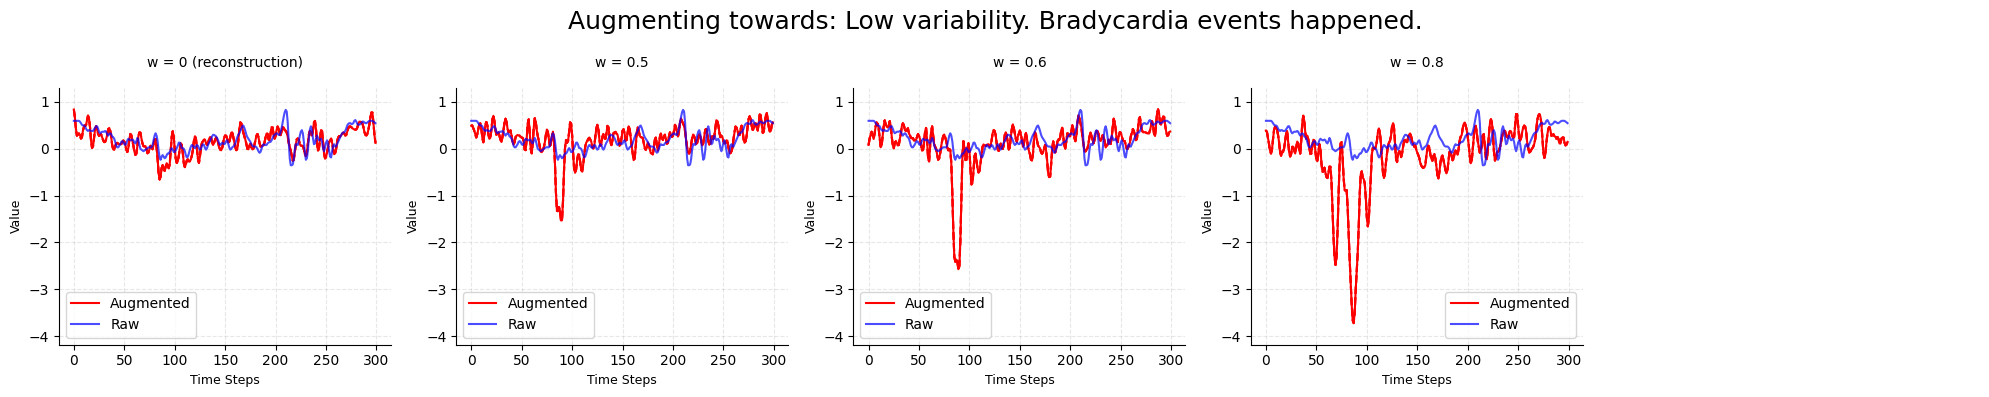

In [8]:
model.eval()
df_train = df_train.set_index('rowid', drop=False)

w_values = [0, 0.5, 0.6, 0.8]
y_col = 'description_ts_event_binary'
ref_level = 'No events.'
tgt_level = 'Bradycardia events happened.'

df_level = df_train.loc[[16134],:] #df[df[y_col] == ref_level].reset_index(drop=True).iloc[[tid]].copy()
df_level['new_text'] = df_level['text'].str.replace(ref_level, tgt_level)
essentials = plot_interpolate_ts_tx_ws_sampling(df_level, model, config_dict, text_cols=['new_text'], w_values = w_values, label = True, b=1, ep=1, ylims = None, return_essentials = True)
ref_color = 'black'#"cornflowerblue"


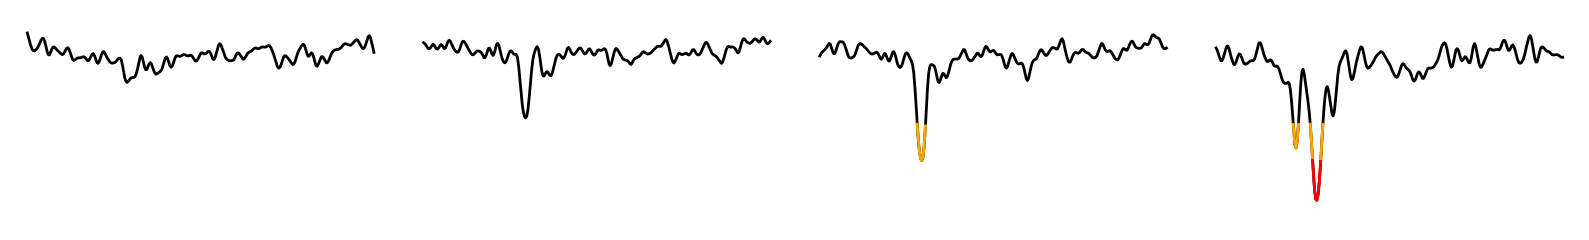

In [9]:

import matplotlib.pyplot as plt
import numpy as np

# --------------------------------------------------------------------------
raw_ts   = essentials["raw_ts"]
medians  = essentials["median"]
w_values = essentials["w_values"]
text_cond = list(essentials["median"].keys())[0]
# --------------------------------------------------------------------------

MEAN, SD = 130, 20
rescale  = lambda a: a * SD + MEAN

ORANGE_THR = 99.5
RED_THR    =  80

def movavg(x, k=3):
    pad = k // 2
    x_pad = np.pad(x, (pad, pad), mode="edge")
    return np.convolve(x_pad, np.ones(k) / k, mode="valid")

# -------- y-limits (unchanged) ---------------------------------------------
all_vals = [rescale(medians[text_cond][float(w)]) for w in w_values]
gmin, gmax = min(v.min() for v in all_vals), max(v.max() for v in all_vals)
ylims = (gmin - 0.1 * (gmax - gmin), gmax + 0.1 * (gmax - gmin))

# -------- reference, then interpolate to 600 pts ---------------------------
ref_q50 = movavg(rescale(medians[text_cond][0.0]), k=3)
orig_len = len(ref_q50)
t_orig = np.arange(orig_len)
t_new  = np.linspace(0, orig_len - 1, 2400)          # <<< INTERPOLATE >>>
ref_q50 = np.interp(t_new, t_orig, ref_q50)         # <<< INTERPOLATE >>>

# -------- grid -------------------------------------------------------------
n_cols = 4
n_rows = int(np.ceil(len(w_values) / n_cols))
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 2.5))
axs = axs.ravel()

for idx, w in enumerate(w_values):
    ax = axs[idx]

    q50 = movavg(rescale(medians[text_cond][float(w)]), k=5)
    q50 = np.interp(t_new, t_orig, q50)             # <<< INTERPOLATE >>>
    x   = t_new                                     # new 600-point axis

    # if w != 0:
    #     ax.plot(x, ref_q50, color="black", linestyle="--", linewidth=1)

    # masks
    mask_red  = q50 <= RED_THR
    mask_red  |= np.roll(mask_red,  1) | np.roll(mask_red, -1)
    mask_orange = (q50 <= ORANGE_THR) & ~mask_red

    # baseline
    ax.plot(x, q50, color=ref_color, linewidth=2) #cornflowerblue
    # overlays
    ax.plot(x, np.ma.masked_where(~mask_orange, q50),
            color="orange", linewidth=2)
    ax.plot(x, np.ma.masked_where(~mask_red, q50),
            color="red",    linewidth=2)

    ax.set_ylim(*ylims)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([])  # Remove x ticks
    ax.set_yticks([])  # Remove x ticks
    ax.set_xticklabels([])  # Remove x tick labels
    ax.set_yticklabels([])  # Remove x tick labels
    ax.axis('off') 

# hide empties
for idx in range(len(w_values), n_rows * n_cols):
    axs[idx].axis("off")

plt.tight_layout()
import os
os.makedirs('./results/paper/figure1', exist_ok=True)
plt.savefig("./results/paper/figure1/before_after_interpolate.png", dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()


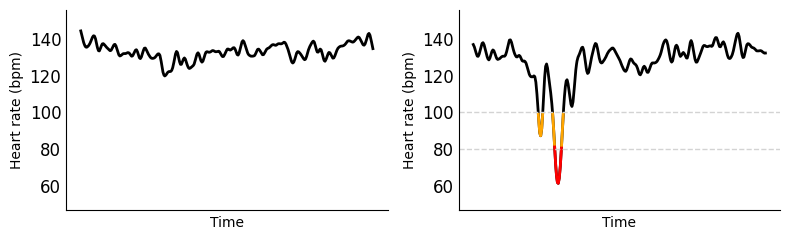

In [7]:
# -------- grid -------------------------------------------------------------
n_cols = 2  # Changed from 4 to 2
n_rows = 1  # Changed to 1 since we only want 2 plots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 2.5))
axs = axs.ravel()

# Only plot first and last w_values
w_values_to_plot = [w_values[0], w_values[-1]]  # First and last values

for idx, w in enumerate(w_values_to_plot):
    ax = axs[idx]

    q50 = movavg(rescale(medians[text_cond][float(w)]), k=5)
    q50 = np.interp(t_new, t_orig, q50)             # <<< INTERPOLATE >>>
    x   = t_new                                     # new 600-point axis

    # masks
    mask_red  = q50 <= RED_THR
    mask_red  |= np.roll(mask_red,  1) | np.roll(mask_red, -1)
    mask_orange = (q50 <= ORANGE_THR) & ~mask_red

    # baseline
    ax.plot(x, q50, color=ref_color, linewidth=2)
    # overlays
    ax.plot(x, np.ma.masked_where(~mask_orange, q50),
            color="orange", linewidth=2)
    ax.plot(x, np.ma.masked_where(~mask_red, q50),
            color="red",    linewidth=2)

    # Add horizontal lines to second plot
    if idx == 1:
        ax.axhline(80, color='lightgray', linestyle='--', linewidth=1)
        ax.axhline(100, color='lightgray', linestyle='--', linewidth=1)

    ax.set_ylim(*ylims)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.tick_params(axis='y', labelsize=12)
    ax.tick_params(axis='both', length=0)
    ax.set_ylabel("Heart rate (bpm)")
    ax.set_xlabel("Time")

plt.tight_layout()
plt.savefig("./results/paper/figure1/before_after.png", dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()


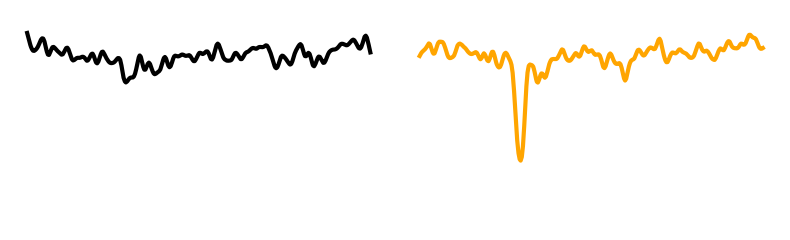

In [8]:
# -------- grid -------------------------------------------------------------
n_cols = 2  # Changed from 4 to 2
n_rows = 1  # Changed to 1 since we only want 2 plots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 2.5))
axs = axs.ravel()

# Only plot first and last w_values
w_values_to_plot = [w_values[0], w_values[-2]]  # First and last values

for idx, w in enumerate(w_values_to_plot):
    ax = axs[idx]

    q50 = movavg(rescale(medians[text_cond][float(w)]), k=5)
    q50 = np.interp(t_new, t_orig, q50)             # <<< INTERPOLATE >>>
    x   = t_new                                     # new 600-point axis

    # if w != 0:
    #     ax.plot(x, ref_q50, color="black", linestyle="--", linewidth=1)

    # masks
    mask_red  = q50 <= RED_THR
    mask_red  |= np.roll(mask_red,  1) | np.roll(mask_red, -1)
    mask_orange = (q50 <= ORANGE_THR) & ~mask_red

    # baseline
    if idx == 0:  # First plot - normal colors 
        ax.plot(x, q50, color=ref_color, linewidth=3)#cornflowerblue
    else:  # Second plot - all orange
        ax.plot(x, q50, color="orange", linewidth=3)


    ax.set_ylim(*ylims)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([])  # Remove x ticks
    ax.set_xticklabels([])  # Remove x tick labels
    ax.tick_params(axis='y', labelsize=12)  # Smaller y tick font
    ax.tick_params(axis='both', length=0)  # Remove tick marks (sticks)
    ax.set_xlabel("Time")  # Add xlabel
    ax.axis('off') 

plt.tight_layout()
plt.savefig("./results/paper/figure1/before_after_abs.png", dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

# fake distribution

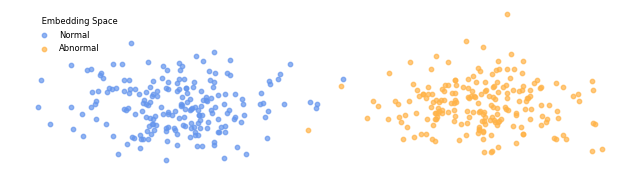

In [10]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)
# Parameters for both distributions
mean_right = [2, 0]     # center of orange distribution
mean_left = [-2, 0]     # center of blue distribution
cov = [[0.5, 0], [0, 0.1]]  # flat, no correlation

# Generate samples
samples_right = np.random.multivariate_normal(mean_right, cov, 200)
samples_left  = np.random.multivariate_normal(mean_left,  cov, 200)

# Plot
plt.figure(figsize=(8, 2))
plt.scatter(samples_left[:, 0],  samples_left[:, 1],  alpha=0.7, color='cornflowerblue', s=10, label='Normal')
plt.scatter(samples_right[:, 0], samples_right[:, 1], alpha=0.7, color='#FFB347', s=10 , label='Abnormal')
plt.legend(title="         Embedding Space", loc='upper left', frameon=False, fontsize=6, title_fontsize=6)

plt.axis("equal")
plt.axis('off')
plt.grid(False)


plt.savefig("./results/paper/figure1/gaussian_clusters.png", dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

# figure 2

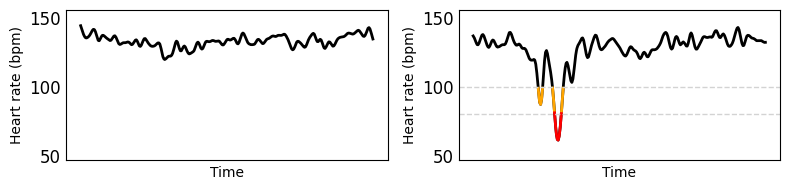

In [11]:
# add a essentials['raw_ts'] as refernece dotted blue line at each subplot. 

# -------- grid -------------------------------------------------------------
n_cols = 2  # Changed from 4 to 2
n_rows = 1  # Changed to 1 since we only want 2 plots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 2))
axs = axs.ravel()

# Only plot first and last w_values
w_values_to_plot = [w_values[0], w_values[-1]]  # First and last values

for idx, w in enumerate(w_values_to_plot):
    ax = axs[idx]

    q50 = movavg(rescale(medians[text_cond][float(w)]), k=5)
    q50 = np.interp(t_new, t_orig, q50)             # <<< INTERPOLATE >>>
    x   = t_new                                     # new 600-point axis

    # masks
    mask_red  = q50 <= RED_THR
    mask_red  |= np.roll(mask_red,  1) | np.roll(mask_red, -1)
    mask_orange = (q50 <= ORANGE_THR) & ~mask_red

    # baseline
    ax.plot(x, q50, color=ref_color, linewidth=2)
    # overlays
    ax.plot(x, np.ma.masked_where(~mask_orange, q50),
            color="orange", linewidth=2)
    ax.plot(x, np.ma.masked_where(~mask_red, q50),
            color="red",    linewidth=2)

    # Add horizontal lines to second plot
    if idx == 1:
        ax.axhline(80, color='lightgray', linestyle='--', linewidth=1)
        ax.axhline(100, color='lightgray', linestyle='--', linewidth=1)

    ax.set_ylim(*ylims)
    # ax.spines['top'].set_visible(False)
    # ax.spines['right'].set_visible(False)
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.tick_params(axis='y', labelsize=12)
    ax.tick_params(axis='both', length=0)
    ax.set_ylabel("Heart rate (bpm)")
    ax.set_xlabel("Time")

plt.tight_layout()
os.makedirs("./results/paper/figure2", exist_ok=True)
plt.savefig("./results/paper/figure2/before_after.png", dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()


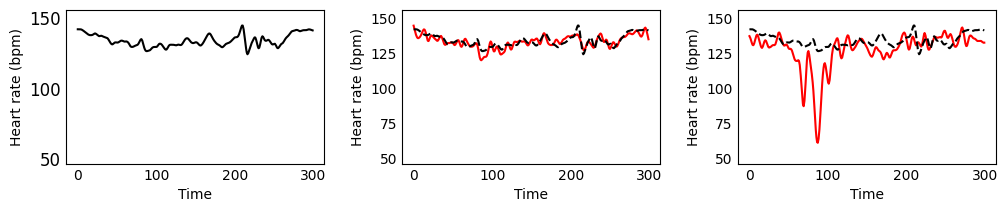

In [14]:
ref_color = "red"
# -------- grid -------------------------------------------------------------
n_cols = 3  # Changed from 2 to 3
n_rows = 1  # Changed to 1 since we only want 3 plots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 2))
axs = axs.ravel()

# First subplot for raw time series only
ax = axs[0]
raw_ts_processed = movavg(rescale(essentials['raw_ts']), k=5)
raw_ts_processed = np.interp(t_new, t_orig, raw_ts_processed)
ax.plot(x, raw_ts_processed, color='black', linewidth=1.5, alpha=1)

ax.set_ylim(*ylims)
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='both', length=0)
ax.set_ylabel("Heart rate (bpm)")
ax.set_xlabel("Time")

# Only plot first and last w_values
w_values_to_plot = [w_values[0], w_values[-1]]  # First and last values

for idx, w in enumerate(w_values_to_plot):
    ax = axs[idx + 1]  # Start from second subplot

    q50 = movavg(rescale(medians[text_cond][float(w)]), k=5)
    q50 = np.interp(t_new, t_orig, q50)             # <<< INTERPOLATE >>>
    x   = t_new                                     # new 600-point axis

    # Process raw_ts with same transformations
    raw_ts_processed = movavg(rescale(essentials['raw_ts']), k=5)
    raw_ts_processed = np.interp(t_new, t_orig, raw_ts_processed)
    # baseline
    ax.plot(x, q50, color=ref_color, linewidth=1.5)
    
    # Add reference dotted blue line with same processing
    ax.plot(x, raw_ts_processed, color='black', linewidth=1.5, linestyle='--', alpha=1)

    
    ax.set_ylim(*ylims)
    # ax.spines['top'].set_visible(False)
    # ax.spines['right'].set_visible(False)
    # ax.set_xticks([])
    # ax.set_xticklabels([])
    ax.tick_params(axis='y', labelsize=10)
    ax.tick_params(axis='both', length=0)
    ax.set_ylabel("Heart rate (bpm)")
    ax.set_xlabel("Time")

plt.subplots_adjust(wspace=0.3)
# plt.tight_layout()
# os.makedirs("./results/paper/figure2", exist_ok=True)
# plt.savefig("./results/paper/figure2/before_after.png", dpi=300, bbox_inches='tight', pad_inches=0)
# plt.show()

HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/paraphrase-mpnet-base-v2/resolve/main/config_sentence_transformers.json
Retrying in 1s [Retry 1/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/paraphrase-mpnet-base-v2/resolve/main/config_sentence_transformers.json
Retrying in 2s [Retry 2/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/paraphrase-mpnet-base-v2/resolve/main/config_sentence_transformers.json
Retrying in 4s [Retry 3/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/paraphrase-mpnet-base-v2/resolve/main/config_sentence_transformers.json
Retrying in 8s [Retry 4/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/paraphrase-mpnet-base-v2/resolve/main/config_sentence_transformers.json
Retrying in 8s [Retry 5/5].
HTTP Error 429 thrown while requesting HEAD https://hug

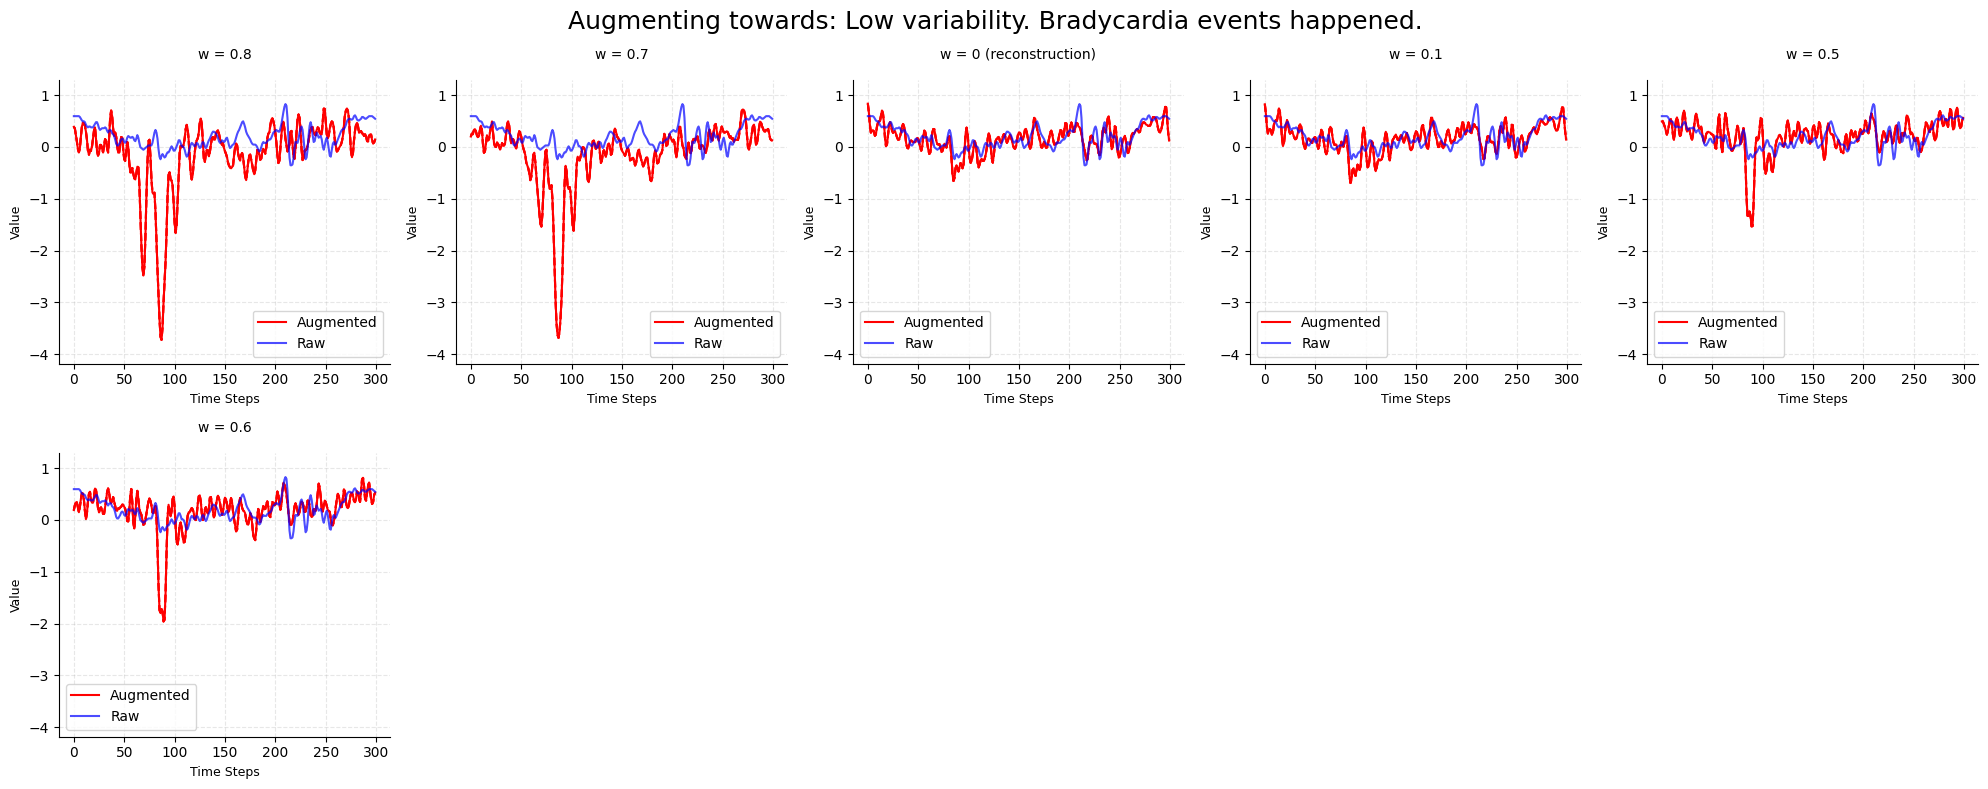

In [24]:
model.eval()
df_train = df_train.set_index('rowid', drop=False)

w_values = [0.8, 0.73, 0.0, 0.1, 0.5, 0.55]
y_col = 'description_ts_event_binary'
ref_level = 'No events.'
tgt_level = 'Bradycardia events happened.'

df_level = df_train.loc[[16134],:] #df[df[y_col] == ref_level].reset_index(drop=True).iloc[[tid]].copy()
df_level['new_text'] = df_level['text'].str.replace(ref_level, tgt_level)
essentials = plot_interpolate_ts_tx_ws_sampling(df_level, model, config_dict, text_cols=['new_text'], w_values = w_values, label = True, b=1, ep=1, ylims = None, return_essentials = True)
ref_color = 'black'#"cornflowerblue"


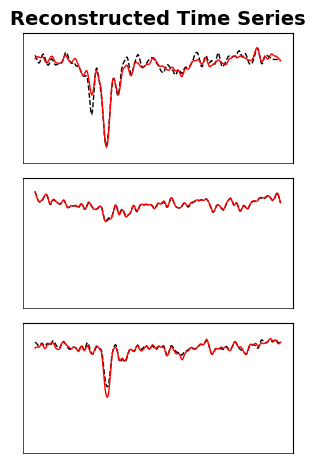

In [51]:
import matplotlib.pyplot as plt
import numpy as np

# --------------------------------------------------------------------------
raw_ts   = essentials["raw_ts"]
medians  = essentials["median"]
w_values = essentials["w_values"]
text_cond = list(essentials["median"].keys())[0]
# --------------------------------------------------------------------------

MEAN, SD = 130, 20
rescale  = lambda a: a * SD + MEAN

ORANGE_THR = 99.5
RED_THR    =  80

def movavg(x, k=3):
    pad = k // 2
    x_pad = np.pad(x, (pad, pad), mode="edge")
    return np.convolve(x_pad, np.ones(k) / k, mode="valid")

# -------- y-limits (unchanged) ---------------------------------------------
all_vals = [rescale(medians[text_cond][float(w)]) for w in w_values]
gmin, gmax = min(v.min() for v in all_vals), max(v.max() for v in all_vals)
ylims = (gmin - 0.1 * (gmax - gmin), gmax + 0.1 * (gmax - gmin))

# -------- reference, then interpolate to 600 pts ---------------------------
ref_q50 = movavg(rescale(medians[text_cond][0.0]), k=3)
orig_len = len(ref_q50)
t_orig = np.arange(orig_len)
t_new  = np.linspace(0, orig_len - 1, 2400)          # <<< INTERPOLATE >>>
ref_q50 = np.interp(t_new, t_orig, ref_q50)         # <<< INTERPOLATE >>>

# -------- grid -------------------------------------------------------------
w_values_main = [0.8, 0.0, 0.5]
w_values_red = [0.73, 0.1, 0.55]#[0.75, 0.05, 0.55]
n_cols = 1
n_rows = len(w_values_main)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 1.5))
axs = axs.ravel()

for idx, w in enumerate(w_values_main):
    ax = axs[idx]

    q50 = movavg(rescale(medians[text_cond][float(w)]), k=5)
    q50 = np.interp(t_new, t_orig, q50)             # <<< INTERPOLATE >>>
    x   = t_new                                     # new 600-point axis

    # if w != 0:
    #     ax.plot(x, ref_q50, color="black", linestyle="--", linewidth=1)

    # masks
    mask_red  = q50 <= RED_THR
    mask_red  |= np.roll(mask_red,  1) | np.roll(mask_red, -1)
    mask_orange = (q50 <= ORANGE_THR) & ~mask_red

    # baseline
    ax.plot(x, q50, color=ref_color, linewidth=1, linestyle='--') #cornflowerblue
    # # overlays
    # ax.plot(x, np.ma.masked_where(~mask_orange, q50),
    #         color="orange", linewidth=2)
    # ax.plot(x, np.ma.masked_where(~mask_red, q50),
    #         color="red",    linewidth=2)
    
    # Add red line for corresponding w_value
    w_red = w_values_red[idx]
    q50_red = movavg(rescale(medians[text_cond][float(w_red)]), k=5)
    q50_red = np.interp(t_new, t_orig, q50_red)
    ax.plot(x, q50_red, color='red', linewidth=1)

    # ax.set_ylim(*ylims)
    # ax.spines['top'].set_visible(False)
    # ax.spines['right'].set_visible(False)
    # ax.tick_params(axis='y', labelsize=10)
    # ax.tick_params(axis='both', length=0)
    # ax.set_ylabel("Heart rate (bpm)")
    # ax.set_xlabel("Time")


    ax.set_ylim(*ylims)
    # ax.spines['top'].set_visible(False)
    # ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])



plt.tight_layout()
plt.suptitle('Reconstructed Time Series', y=1.02, fontsize=14, weight = "bold")
import os
os.makedirs('./results/paper/figure2', exist_ok=True)
plt.savefig("./results/paper/figure2/ts_reconstruction.png", dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

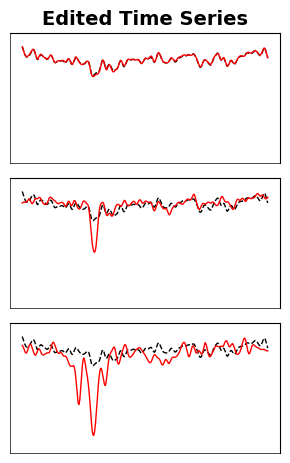

In [52]:
import matplotlib.pyplot as plt
import numpy as np

# --------------------------------------------------------------------------
raw_ts   = essentials["raw_ts"]
medians  = essentials["median"]
w_values = essentials["w_values"]
text_cond = list(essentials["median"].keys())[0]
# --------------------------------------------------------------------------

MEAN, SD = 130, 20
rescale  = lambda a: a * SD + MEAN

ORANGE_THR = 99.5
RED_THR    =  80

def movavg(x, k=3):
    pad = k // 2
    x_pad = np.pad(x, (pad, pad), mode="edge")
    return np.convolve(x_pad, np.ones(k) / k, mode="valid")

# -------- y-limits (unchanged) ---------------------------------------------
all_vals = [rescale(medians[text_cond][float(w)]) for w in w_values]
gmin, gmax = min(v.min() for v in all_vals), max(v.max() for v in all_vals)
ylims = (gmin - 0.1 * (gmax - gmin), gmax + 0.1 * (gmax - gmin))

# -------- reference, then interpolate to 600 pts ---------------------------
ref_q50 = movavg(rescale(medians[text_cond][0.0]), k=3)
orig_len = len(ref_q50)
t_orig = np.arange(orig_len)
t_new  = np.linspace(0, orig_len - 1, 2400)          # <<< INTERPOLATE >>>
ref_q50 = np.interp(t_new, t_orig, ref_q50)         # <<< INTERPOLATE >>>

# -------- grid -------------------------------------------------------------
w_values_main = [0.0, 0.0, 0.0]
w_values_red = [0.1, 0.55, 0.8]#[0.75, 0.05, 0.55]
n_cols = 1
n_rows = len(w_values_main)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 1.5))
axs = axs.ravel()

for idx, w in enumerate(w_values_main):
    ax = axs[idx]

    q50 = movavg(rescale(medians[text_cond][float(w)]), k=5)
    q50 = np.interp(t_new, t_orig, q50)             # <<< INTERPOLATE >>>
    x   = t_new                                     # new 600-point axis

    # if w != 0:
    #     ax.plot(x, ref_q50, color="black", linestyle="--", linewidth=1)

    # masks
    mask_red  = q50 <= RED_THR
    mask_red  |= np.roll(mask_red,  1) | np.roll(mask_red, -1)
    mask_orange = (q50 <= ORANGE_THR) & ~mask_red

    # baseline
    ax.plot(x, q50, color=ref_color, linewidth=1, linestyle='--') #cornflowerblue
    # # overlays
    # ax.plot(x, np.ma.masked_where(~mask_orange, q50),
    #         color="orange", linewidth=2)
    # ax.plot(x, np.ma.masked_where(~mask_red, q50),
    #         color="red",    linewidth=2)
    
    # Add red line for corresponding w_value
    w_red = w_values_red[idx]
    q50_red = movavg(rescale(medians[text_cond][float(w_red)]), k=5)
    q50_red = np.interp(t_new, t_orig, q50_red)
    ax.plot(x, q50_red, color='red', linewidth=1)

    # ax.set_ylim(*ylims)
    # ax.spines['top'].set_visible(False)
    # ax.spines['right'].set_visible(False)
    # ax.tick_params(axis='y', labelsize=10)
    # ax.tick_params(axis='both', length=0)
    # ax.set_ylabel("Heart rate (bpm)")
    # ax.set_xlabel("Time")

    ax.set_ylim(*ylims)
    # ax.spines['top'].set_visible(False)
    # ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

plt.tight_layout()
plt.suptitle('Edited Time Series', y=1.02, fontsize=14, weight = "bold")
import os
os.makedirs('./results/paper/figure2', exist_ok=True)
plt.savefig("./results/paper/figure2/ts_gen.png", dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

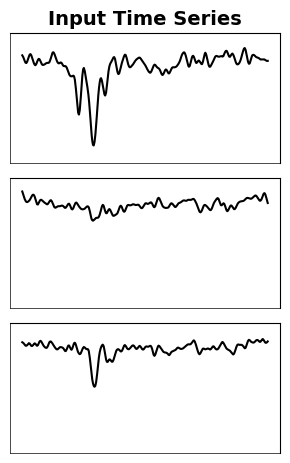

In [53]:
import matplotlib.pyplot as plt
import numpy as np

# --------------------------------------------------------------------------
raw_ts   = essentials["raw_ts"]
medians  = essentials["median"]
w_values = essentials["w_values"]
text_cond = list(essentials["median"].keys())[0]
# --------------------------------------------------------------------------

MEAN, SD = 130, 20
rescale  = lambda a: a * SD + MEAN

ORANGE_THR = 99.5
RED_THR    =  80

def movavg(x, k=3):
    pad = k // 2
    x_pad = np.pad(x, (pad, pad), mode="edge")
    return np.convolve(x_pad, np.ones(k) / k, mode="valid")

# -------- y-limits (unchanged) ---------------------------------------------
all_vals = [rescale(medians[text_cond][float(w)]) for w in w_values]
gmin, gmax = min(v.min() for v in all_vals), max(v.max() for v in all_vals)
ylims = (gmin - 0.1 * (gmax - gmin), gmax + 0.1 * (gmax - gmin))

# -------- reference, then interpolate to 600 pts ---------------------------
ref_q50 = movavg(rescale(medians[text_cond][0.0]), k=3)
orig_len = len(ref_q50)
t_orig = np.arange(orig_len)
t_new  = np.linspace(0, orig_len - 1, 2400)          # <<< INTERPOLATE >>>
ref_q50 = np.interp(t_new, t_orig, ref_q50)         # <<< INTERPOLATE >>>

# -------- grid -------------------------------------------------------------
w_values = [0.8, 0.0, 0.5]
n_cols = 1
n_rows = len(w_values)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 1.5))
axs = axs.ravel()

for idx, w in enumerate(w_values):
    ax = axs[idx]

    q50 = movavg(rescale(medians[text_cond][float(w)]), k=5)
    q50 = np.interp(t_new, t_orig, q50)             # <<< INTERPOLATE >>>
    x   = t_new                                     # new 600-point axis

    # if w != 0:
    #     ax.plot(x, ref_q50, color="black", linestyle="--", linewidth=1)

    # masks
    mask_red  = q50 <= RED_THR
    mask_red  |= np.roll(mask_red,  1) | np.roll(mask_red, -1)
    mask_orange = (q50 <= ORANGE_THR) & ~mask_red

    # baseline
    ax.plot(x, q50, color=ref_color, linewidth=1.5) #cornflowerblue
    # # overlays
    # ax.plot(x, np.ma.masked_where(~mask_orange, q50),
    #         color="orange", linewidth=2)
    # ax.plot(x, np.ma.masked_where(~mask_red, q50),
    #         color="red",    linewidth=2)

    # ax.set_ylim(*ylims)
    # ax.spines['top'].set_visible(False)
    # ax.spines['right'].set_visible(False)
    # ax.tick_params(axis='y', labelsize=10)
    # ax.tick_params(axis='both', length=0)
    # ax.set_ylabel("Heart rate (bpm)")
    # ax.set_xlabel("Time")

    ax.set_ylim(*ylims)
    # ax.spines['top'].set_visible(False)
    # ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])



plt.tight_layout()
plt.suptitle('Input Time Series', y=1.02, fontsize=14, weight = "bold")
import os
os.makedirs('./results/paper/figure2', exist_ok=True)
plt.savefig("./results/paper/figure2/ts.png", dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

In [37]:
# import matplotlib.pyplot as plt
# from matplotlib.patches import Rectangle

# B = 5  # Size of the matrix

# fig, ax = plt.subplots(figsize=(4, 4))  # Square figure
# ax.set_xlim(0, B)
# ax.set_ylim(0, B)
# ax.set_aspect('equal')  # This enforces square cells
# ax.axis('off')

# # Draw cells
# for i in range(B):
#     for j in range(B):
#         color = '#9FC5E8' if i == j else '#CFE2F3'
#         ax.add_patch(Rectangle((j, B - 1 - i), 1, 1, facecolor=color, edgecolor='black'))

#         # Add label centered
#         ax.text(j + 0.5, B - 1 - i + 0.5, f'$x_{{{i+1}}} \\cdot c_{{{j+1}}}$',
#                 ha='center', va='center', fontsize=12)

# import os
# os.makedirs('./results/paper/figure2', exist_ok=True)
# plt.savefig("./results/paper/figure2/clip.png", dpi=300, bbox_inches='tight', pad_inches=0)
# plt.show()


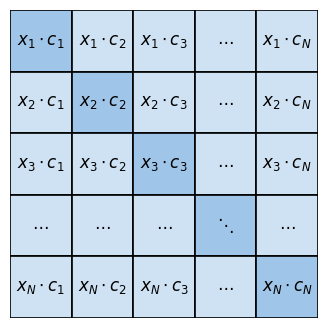

In [41]:
# import matplotlib.pyplot as plt
# from matplotlib.patches import Rectangle

# # --- Configuration ---
# shown = [1, 2, 3]               # Leading indices to show
# ellipsis_token = '...'
# last_token = 'N'
# rows = shown + [ellipsis_token] + [last_token]
# cols = shown + [ellipsis_token] + [last_token]
# n = len(rows)

# # --- Setup figure ---
# fig, ax = plt.subplots(figsize=(4, 4))
# ax.set_xlim(0, n)
# ax.set_ylim(0, n)
# ax.set_aspect("equal")
# ax.axis('off')

# # --- Colors ---
# diag_dark = '#9FC5E8'   # Dark blue (diagonal)
# off_light = '#CFE2F3'   # Light blue (off-diagonal)

# # --- Draw cells ---
# for i_r, r in enumerate(rows):
#     for i_c, c in enumerate(cols):
#         is_diag = i_r == i_c  # All diagonal cells use dark blue
#         color = diag_dark if is_diag else off_light

#         # Draw 1×1 square
#         ax.add_patch(Rectangle((i_c, n - 1 - i_r), 1, 1,
#                                facecolor=color, edgecolor='black', linewidth=1.2))

#         # Determine label
#         if r == ellipsis_token and c == ellipsis_token:
#             label = r'$\ddots$'
#         elif r == ellipsis_token or c == ellipsis_token:
#             label = r'$\cdots$'
#         else:
#             label = rf'$x_{{{r}}} \cdot c_{{{c}}}$'

#         # Center text
#         ax.text(i_c + 0.5, n - 1 - i_r + 0.5,
#                 label, ha='center', va='center', fontsize=12)

# import os
# os.makedirs('./results/paper/figure2', exist_ok=True)
# plt.savefig("./results/paper/figure2/clip.png", dpi=300, bbox_inches='tight', pad_inches=0)
# plt.show()

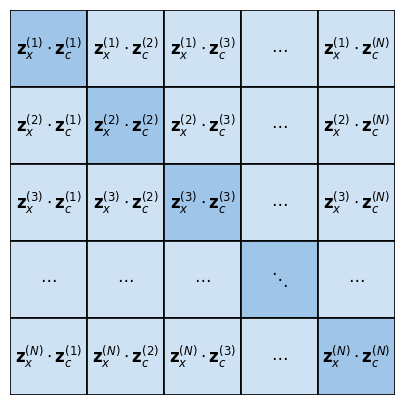

In [47]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import os

# --- Configuration ---
shown = [1, 2, 3]
ellipsis_token = '...'
last_token = 'N'
rows = shown + [ellipsis_token] + [last_token]
cols = shown + [ellipsis_token] + [last_token]
n = len(rows)

# --- Setup figure ---
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xlim(0, n)
ax.set_ylim(0, n)
ax.set_aspect("equal")
ax.axis('off')

# --- Colors ---
diag_dark = '#9FC5E8'
off_light = '#CFE2F3'

# --- Draw cells ---
for i_r, r in enumerate(rows):
    for i_c, c in enumerate(cols):
        is_diag = i_r == i_c
        color = diag_dark if is_diag else off_light

        # Draw square cell
        ax.add_patch(Rectangle((i_c, n - 1 - i_r), 1, 1,
                               facecolor=color, edgecolor='black', linewidth=1.2))

        # Determine label
        if r == ellipsis_token and c == ellipsis_token:
            label = r'$\ddots$'
        elif r == ellipsis_token or c == ellipsis_token:
            label = r'$\cdots$'
        else:
            label = rf'$\mathbf{{z}}_x^{{({r})}} \cdot \mathbf{{z}}_c^{{({c})}}$'

        ax.text(i_c + 0.5, n - 1 - i_r + 0.5,
                label, ha='center', va='center', fontsize=12)

# --- Save output ---
os.makedirs('./results/paper/figure2', exist_ok=True)
plt.savefig("./results/paper/figure2/clip.png", dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()


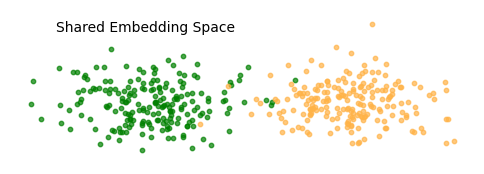

In [57]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)
# Parameters for both distributions
mean_right = [1.5, 0]     # center of orange distribution
mean_left = [-1.5, 0]     # center of blue distribution
cov = [[0.5, 0], [0, 0.1]]  # flat, no correlation

# Generate samples
samples_right = np.random.multivariate_normal(mean_right, cov, 200)
samples_left  = np.random.multivariate_normal(mean_left,  cov, 200)

# Plot
plt.figure(figsize=(6, 2))
plt.scatter(samples_left[:, 0],  samples_left[:, 1],  alpha=0.7, color='green', s=10, label='Normal')
plt.scatter(samples_right[:, 0], samples_right[:, 1], alpha=0.7, color='#FFB347', s=10 , label='Abnormal')
# plt.legend(title="         Embedding Space", loc='upper left', frameon=False, fontsize=6, title_fontsize=6)

plt.axis("equal")
plt.axis('off')
plt.title('Shared Embedding Space', fontsize=10, loc='left', y=0.8, x=0.1)
plt.grid(False)


plt.savefig("./results/paper/figure2/gaussian_clusters.png", dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()